## Jordi Blasco Lozano  
### Generación de grafos matcheados – Parte 1

- #### PYTHONPATH para el DataLoader

In [14]:
import sys
import os

# Agrega el directorio padre (la raíz del proyecto) al sys.path
sys.path.append(os.path.abspath('..'))


- #### Librerías y Configuración Inicial

    En este bloque se importan las librerías necesarias para la visualización, generación de grafos, generación de triangulaciones y matcheos

    También se importa el módulo **DataLoader** para cargar nuestro dataset de paths.

In [46]:

import numpy as np
from PIL import Image
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay, distance
from scipy.optimize import linear_sum_assignment
import pandas as pd
import random
import logging
import matplotlib.colors as mcolors

from data.dataloader import DataLoader


- #### Configuración del logger
    En esta practica usaremos la librería logging para generar la información de depuración, de esta manera en vez de hacer `prints` normales, usaremos en livel de log de info para que en el momento de ejecución del programa sepamos que está haciendo nuestro programa en todo momento. Así quedará más clara la forma de funcionar del mismo

In [16]:

logging.basicConfig(
    level=logging.INFO,
    format='[%(asctime)s] %(levelname)s: %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)
logger = logging.getLogger(__name__)
logger.info(f'Logging level: {logging.getLevelName(logger.getEffectiveLevel())}')



[2025-02-23 10:46:14] INFO: Logging level: INFO


- #### Carga del Dataset

    A continuación, se instancia la clase **DataLoader** para cargar los datos.
    El DataFrame resultante contiene todas las rutas de las imágenes y los archivos que contienen los keypoints, permitiendo acceder a la información de cada categoría.

In [35]:
    # Instanciar el DataLoader y cargar los dataframes
    dl = DataLoader()
    dlf = dl.load_data()

- #### Carga de imagenes y plotteo de par de Imagenes 
    Esta vez no redimensionaremos las imágenes, buscaremos el path en la columna correspondiente a la categoria y devolveremos las imagenes con sus keypoints

    Usaremos una funcion para plotear cada par de imagenes que obtendra como parametros las imagenes, los puntos  

In [84]:

def load_img_and_keypoints_from_row(row):

    img_path = row['img']
    mat_path = row['mat']

    img = np.array(Image.open(img_path).convert("RGB"))
    kpts = np.array(sio.loadmat(mat_path)['pts_coord'])

    return img, kpts

def visualize_combined(img1, img2, kpts1, kpts2, adj_matrix1, adj_matrix2, matching):
    """
    Visualiza de forma combinada dos imágenes, mostrando sus keypoints, grafos de Delaunay y correspondencias (matching).

    La función crea una imagen compuesta colocando las dos imágenes lado a lado. Sobre dicha imagen se dibujan:
      - El grafo de Delaunay para cada imagen, utilizando la matriz de adyacencia (adj_matrix1 y adj_matrix2).
      - Los keypoints detectados sobre cada imagen.
      - Las líneas de matching entre los keypoints de ambas imágenes, donde las correspondencias correctas
        (cuando el índice del keypoint coincide en ambas imágenes) se muestran en verde y las incorrectas en rojo.

    Parámetros:
      img1 (numpy.ndarray): Primera imagen en formato RGB.
      img2 (numpy.ndarray): Segunda imagen en formato RGB.
      kpts1 (numpy.ndarray): Matriz de keypoints de la primera imagen con forma (2, N), donde N es el número de keypoints.
      kpts2 (numpy.ndarray): Matriz de keypoints de la segunda imagen con forma (2, N).
      adj_matrix1 (numpy.ndarray): Matriz de adyacencia de la primera imagen que indica las conexiones entre keypoints.
      adj_matrix2 (numpy.ndarray): Matriz de adyacencia de la segunda imagen.
      matching (numpy.ndarray): Matriz binaria en la que un valor 1 en la posición (i, j) indica que el keypoint i de la
                                primera imagen se corresponde con el keypoint j de la segunda imagen.

    Retorna:
      None. La función muestra la visualización utilizando matplotlib.
    """

    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]
    composite_img = np.zeros((max(h1, h2), w1 + w2, 3), dtype=np.uint8)
    composite_img[:h1, :w1, :] = img1
    composite_img[:h2, w1:w1+w2, :] = img2

    # Trasladar keypoints de la segunda imagen
    kpts2_shifted = kpts2.copy()
    kpts2_shifted[0, :] += w1

    plt.figure(figsize=(10, 10))
    plt.imshow(composite_img)
    

    color = mcolors.CSS4_COLORS['yellow']


    # Dibujar grafos de Delaunay para ambas imágenes
    for kpts, adj_matrix in zip([kpts1, kpts2_shifted], [adj_matrix1, adj_matrix2]):
        N = kpts.shape[1]
        for i in range(N):
            for j in range(i+1, N):
                if adj_matrix[i, j]:
                    plt.plot([kpts[0, i], kpts[0, j]], [kpts[1, i], kpts[1, j]], '-', color=color, linewidth=1)
        plt.scatter(kpts[0], kpts[1], c=color, edgecolors='w', s=80)
    
    # Dibujar matching entre keypoints
    row_ind, col_ind = np.where(matching == 1)
    for r, c in zip(row_ind, col_ind):
        x1, y1 = kpts1[:, r]
        x2, y2 = kpts2_shifted[:, c]
        # Si el índice coincide se pinta en verde
        if r == c:
            plt.plot([x1, x2], [y1, y2], '-',color=mcolors.CSS4_COLORS['lime'] ,linewidth=1)
        else:
            plt.plot([x1, x2], [y1, y2], 'r-', linewidth=1)
    
    plt.title("Matching y Triangulación Delaunay")
    plt.axis("off")
    plt.show()


In [74]:

def delaunay_triangulation(kpts):
    pts = kpts.T
    tri = Delaunay(pts)
    N = pts.shape[0]
    A = np.zeros((N, N))
    for simplex in tri.simplices:
        for i in range(len(simplex)):
            for j in range(i+1, len(simplex)):
                A[simplex[i], simplex[j]] = 1
                A[simplex[j], simplex[i]] = 1
    return A

def simple_spatial_matching(kpts1, kpts2):
    pts1 = kpts1.T
    pts2 = kpts2.T
    cost_matrix = distance.cdist(pts1, pts2, metric="euclidean")
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    matching = np.zeros(cost_matrix.shape, dtype=int)
    matching[row_ind, col_ind] = 1
    return matching


In [86]:



def evaluate_matching_precision(kpts1, matching):
    """
    Se asume que la correspondencia ideal es la diagonal de la matriz de matching.
    """
    N = kpts1.shape[1]
    row_ind, col_ind = np.where(matching == 1)
    correct = np.sum(row_ind == col_ind)
    return correct / N if N != 0 else 0

def compute_precision_for_categories(dlf):
    """
    Para cada categoría:
    1. Selecciona un par aleatorio de imágenes y muestra la visualización.
    2. Compara cada grafo con cada grafo (todos contra todos, sin repetir) y calcula la precisión para cada par.
    3. Acumula los resultados en una lista y al finalizar genera un único CSV (results.csv) con:
         Category,Mean_Accuracy,Std_Deviation,Number_of_Images
    """
    
    overall_results = []  # Acumula los resultados globales
    for cat_name, cat_df in dlf.items():
        if len(cat_df) < 2:
            logger.info(f"No hay suficientes imágenes en {cat_name}")
            continue
        
        # Seleccionar de forma aleatoria un par para visualización
        idx1, idx2 = random.sample(range(len(cat_df)), 2)
        row1 = cat_df.iloc[idx1]
        row2 = cat_df.iloc[idx2]
        img1, kpts1 = load_img_and_keypoints_from_row(row1)
        img2, kpts2 = load_img_and_keypoints_from_row(row2)
        adj1 = delaunay_triangulation(kpts1)
        adj2 = delaunay_triangulation(kpts2)
        matching = simple_spatial_matching(kpts1, kpts2)
        logger.info(f"Visualizando par aleatorio para {cat_name}")
        visualize_combined(img1, img2, kpts1, kpts2, adj1, adj2, matching)
        
        # Calcular la precisión para cada par de imágenes (comparación de todos contra todos)
        precisions = []
        n = len(cat_df)
        for i in range(n - 1):
            for j in range(i + 1, n):
                row_a = cat_df.iloc[i]
                row_b = cat_df.iloc[j]
                img_a, kpts_a = load_img_and_keypoints_from_row(row_a)
                img_b, kpts_b = load_img_and_keypoints_from_row(row_b)
                matching_pair = simple_spatial_matching(kpts_a, kpts_b)
                prec = evaluate_matching_precision(kpts_a, matching_pair)
                precisions.append(prec)
        
        # Calcular estadísticas agregadas
        media = np.mean(precisions)
        std = np.std(precisions)
        
        # Log e información de resultados por categoría
        logger.info(f"Categoría {cat_name.capitalize()}: Precisión media = {media:.4f}, Desviación = {std:.4f}")
        logger.info(f"Resultados procesados para {cat_name} con {len(cat_df)} imágenes")
        
        # Acumular resultados globales
        overall_results.append({
            "Category": cat_name,
            "Mean_Accuracy": round(media, 4),
            "Std_Deviation": round(std, 4),
            "Number_of_Images": n
        })
    
    # Generar único CSV global con los datos de todas las categorías
    overall_df = pd.DataFrame(overall_results)
    overall_df.to_csv("results.csv", index=False)
    logger.info("Resultados globales guardados en results.csv")
    return overall_df

[2025-02-23 11:40:59] INFO: Visualizando par aleatorio para car_df


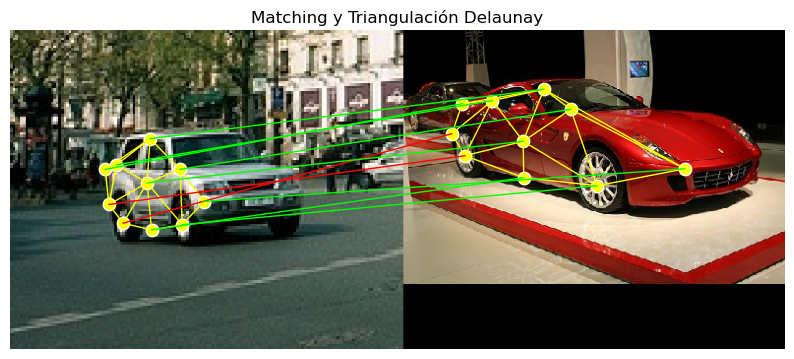

[2025-02-23 11:41:03] INFO: Categoría Car_df: Precisión media = 0.7118, Desviación = 0.3007
[2025-02-23 11:41:03] INFO: Resultados procesados para car_df con 40 imágenes
[2025-02-23 11:41:03] INFO: Visualizando par aleatorio para duck_df


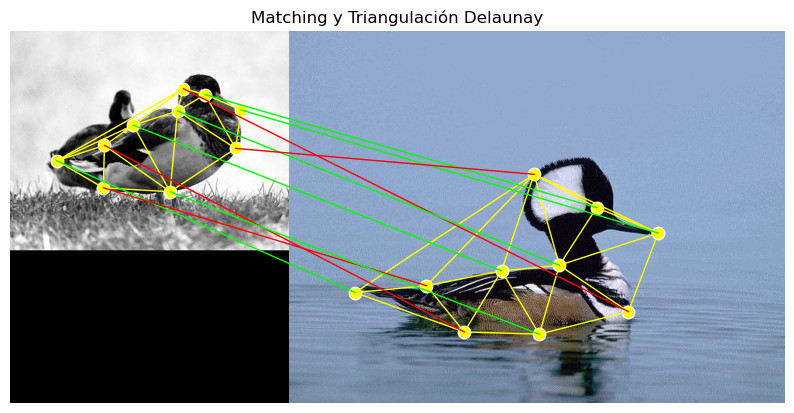

[2025-02-23 11:41:15] INFO: Categoría Duck_df: Precisión media = 0.6753, Desviación = 0.2878
[2025-02-23 11:41:15] INFO: Resultados procesados para duck_df con 50 imágenes
[2025-02-23 11:41:15] INFO: Visualizando par aleatorio para face_df


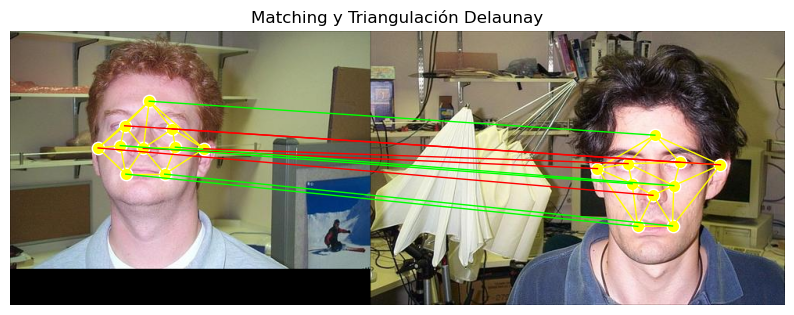

[2025-02-23 11:42:03] INFO: Categoría Face_df: Precisión media = 0.8452, Desviación = 0.1879
[2025-02-23 11:42:03] INFO: Resultados procesados para face_df con 109 imágenes
[2025-02-23 11:42:03] INFO: Visualizando par aleatorio para motorbike_df


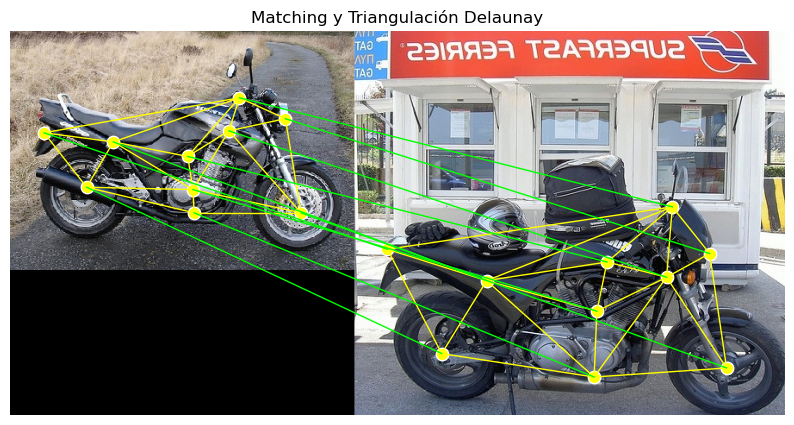

[2025-02-23 11:42:08] INFO: Categoría Motorbike_df: Precisión media = 0.8265, Desviación = 0.2302
[2025-02-23 11:42:08] INFO: Resultados procesados para motorbike_df con 40 imágenes
[2025-02-23 11:42:08] INFO: Visualizando par aleatorio para winebottle_df


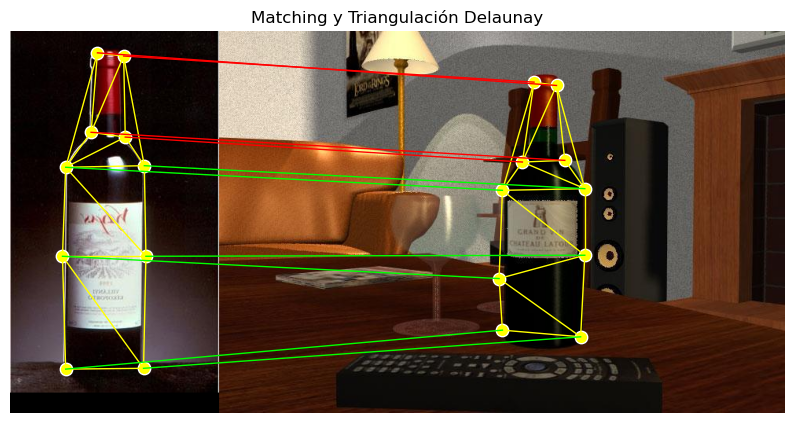

[2025-02-23 11:42:20] INFO: Categoría Winebottle_df: Precisión media = 0.8826, Desviación = 0.1792
[2025-02-23 11:42:20] INFO: Resultados procesados para winebottle_df con 66 imágenes
[2025-02-23 11:42:20] INFO: No hay suficientes imágenes en __pycache___df
[2025-02-23 11:42:20] INFO: Resultados globales guardados en results.csv


In [89]:
if __name__ == "__main__":
    
    final_results = compute_precision_for_categories(dlf)

## RESULTADOS FINALES


In [90]:
final_results

,Category,Mean_Accuracy,Std_Deviation,Number_of_Images
0,car_df,0.7118,0.3007,40
1,duck_df,0.6753,0.2878,50
2,face_df,0.8452,0.1879,109
3,motorbike_df,0.8265,0.2302,40
4,winebottle_df,0.8826,0.1792,66
